In [4]:
# -----------------------------------------------------------------------------
# 1. LIBRERÍAS - DATOS
# -----------------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error

# !pip install pmdarima
from pmdarima import auto_arima
from pmdarima.arima import ARIMA

# Cargar (recupera el ?ndice y tipos autom?ticamente)
df_final = pd.read_pickle('dataset_tesis_final.pkl')
print("Dataset cargado. Dimensiones:", df_final.shape)

# Configuraci?n de gr?ficos
plt.style.use('seaborn-v0_8-darkgrid')


Dataset cargado. Dimensiones: (4496, 15)


Resultados del Test de Dickey-Fuller para: EMBI Nivel (Puntos)
Test Statistic                   -4.846277
p-value                           0.000044
#Lags Used                       28.000000
Number of Observations Used    4467.000000
Critical Value (1%)              -3.431815
Critical Value (5%)              -2.862187
Critical Value (10%)             -2.567115
dtype: float64
CONCLUSIÓN: La serie es ESTACIONARIA (Podemos usarla directamente).
Entrenamiento: 2008-01-31 00:00:00 -> 2022-05-19 00:00:00 (3596 días)
Validación:    2022-05-20 00:00:00 -> 2024-03-11 00:00:00 (450 días)
Prueba (Test): 2024-03-12 00:00:00 -> 2025-12-30 00:00:00 (450 días)


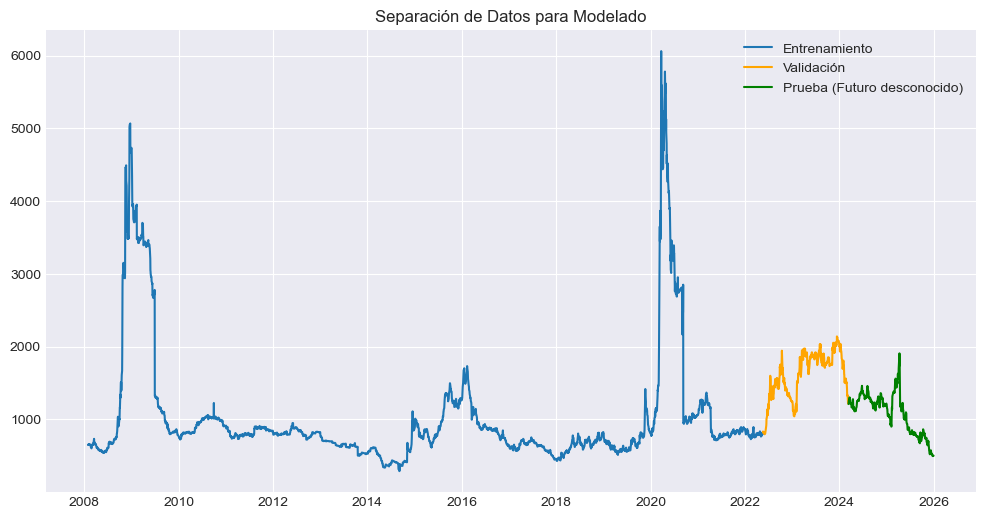

Buscando los mejores parámetros ARIMA (esto puede tardar unos minutos)...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=41674.812, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=41688.481, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=41677.906, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=41679.650, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=41686.483, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=41649.783, Time=4.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41659.459, Time=0.81 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=41614.497, Time=4.62 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41640.453, Time=0.38 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=41615.434, Time=2.50 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=41559.964, Time=4.32 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=41643.503, Time=3.28 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=41613.932, Time=5.22 sec
 ARIMA(3,1,3

In [5]:
# -----------------------------------------------------------------------------
# 2. ANÁLISIS DE ESTACIONARIEDAD (ADF Test)
# -----------------------------------------------------------------------------
def test_stationarity(timeseries, title):
    print(f"Resultados del Test de Dickey-Fuller para: {title}")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    print(dfoutput)

    if dfoutput['p-value'] < 0.05:
        print("CONCLUSIÓN: La serie es ESTACIONARIA (Podemos usarla directamente).")
    else:
        print("CONCLUSIÓN: La serie NO es estacionaria (Tiene tendencia/media variable). Requiere Diferenciación (d=1).")

# Probamos con la serie original del EMBI (sobre todo el hist?rico para diagn?stico)
test_stationarity(df_final['target_embi'], "EMBI Nivel (Puntos)")

# -----------------------------------------------------------------------------
# 3. SPLIT TRAIN / VAL / TEST (CRONOLÓGICO)
# -----------------------------------------------------------------------------
train_end = int(len(df_final) * 0.8)
val_end = int(len(df_final) * 0.9)

train_data = df_final.iloc[:train_end]
val_data = df_final.iloc[train_end:val_end]
test_data = df_final.iloc[val_end:]

print(f"Entrenamiento: {train_data.index.min()} -> {train_data.index.max()} ({len(train_data)} días)")
print(f"Validación:    {val_data.index.min()} -> {val_data.index.max()} ({len(val_data)} días)")
print(f"Prueba (Test): {test_data.index.min()} -> {test_data.index.max()} ({len(test_data)} días)")

# Visualización del corte
plt.figure(figsize=(12, 6))
plt.plot(train_data['target_embi'], label='Entrenamiento')
plt.plot(val_data['target_embi'], label='Validación', color='orange')
plt.plot(test_data['target_embi'], label='Prueba (Futuro desconocido)', color='green')
plt.title("Separación de Datos para Modelado")
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# 4. MODELADO BASELINE: AUTO-ARIMA (sobre TRAIN)
# -----------------------------------------------------------------------------
print("Buscando los mejores parámetros ARIMA (esto puede tardar unos minutos)...")

# auto_arima prueba m?ltiples combinaciones de p,d,q y escoge la de menor AIC
model_arima = auto_arima(train_data['target_embi'],
                         start_p=1, start_q=1,
                         max_p=5, max_q=5,
                         m=1,              # Frecuencia estacional (1 = sin estacionalidad compleja diaria)
                         d=None,           # Dejar que el modelo determine si diferenciar
                         seasonal=False,   # Empezamos sin estacionalidad anual para no complicar
                         stepwise=True,
                         trace=True,       # Para ver el progreso
                         error_action='ignore',
                         suppress_warnings=True)

print(f"Mejor Modelo encontrado: {model_arima.summary()}")
print(f"Orden ARIMA seleccionado: {model_arima.order}")


c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a suppor

VALIDACIÓN ROLLING (Ventana fija):
RMSE: 89.30 puntos básicos
MAE:  61.46 puntos básicos


c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\danny\anaconda3\envs\tesis_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a suppor

RESULTADOS FINALES EN TEST (Rolling Window):
RMSE: 89.64 puntos básicos
MAE:  45.93 puntos básicos


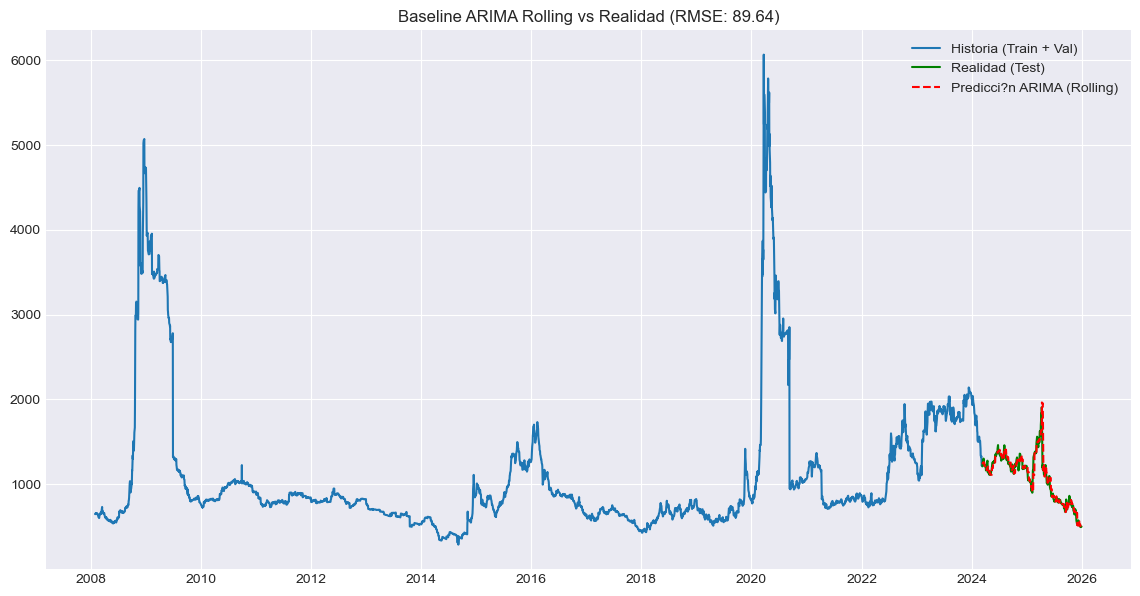

In [6]:
# -----------------------------------------------------------------------------
# 5. VALIDACIÓN ROLLING (VENTANA FIJA) Y EVALUACI?N FINAL
# -----------------------------------------------------------------------------
WINDOW_SIZE = 252 * 3  # ~3 años de trading
STEP = 5  # avanza en bloques para acelerar (1 = paso diario)


def rolling_forecast_arima(history, future, order, seasonal_order, window_size, step=1):
    'Walk-forward con ventana fija. Reentrena en cada paso sobre la última ventana.'
    preds = []
    idxs = []

    hist = history.copy()
    n = len(future)
    i = 0

    while i < n:
        # Ventana fija
        if len(hist) > window_size:
            window_data = hist.iloc[-window_size:]
        else:
            window_data = hist

        model = ARIMA(order=order, seasonal_order=seasonal_order, suppress_warnings=True)
        model.fit(window_data)

        n_periods = min(step, n - i)
        forecast = model.predict(n_periods=n_periods)

        preds.extend(forecast)
        idxs.extend(future.index[i:i+n_periods])

        # Actualizamos con datos reales
        hist = pd.concat([hist, future.iloc[i:i+n_periods]])
        i += n_periods

    return pd.Series(preds, index=idxs)


# Validaci?n rolling sobre el set de VALIDACI?N
order = model_arima.order
seasonal_order = model_arima.seasonal_order

pred_val = rolling_forecast_arima(
    train_data['target_embi'],
    val_data['target_embi'],
    order=order,
    seasonal_order=seasonal_order,
    window_size=WINDOW_SIZE,
    step=STEP
)

rmse_val = np.sqrt(mean_squared_error(val_data['target_embi'], pred_val))
mae_val = mean_absolute_error(val_data['target_embi'], pred_val)

print(f"VALIDACIÓN ROLLING (Ventana fija):")
print(f"RMSE: {rmse_val:.2f} puntos básicos")
print(f"MAE:  {mae_val:.2f} puntos básicos")

# Evaluación final sobre TEST (usando history = train + val)
history_tv = pd.concat([train_data['target_embi'], val_data['target_embi']])

pred_test = rolling_forecast_arima(
    history_tv,
    test_data['target_embi'],
    order=order,
    seasonal_order=seasonal_order,
    window_size=WINDOW_SIZE,
    step=STEP
)

rmse_test = np.sqrt(mean_squared_error(test_data['target_embi'], pred_test))
mae_test = mean_absolute_error(test_data['target_embi'], pred_test)

print(f"RESULTADOS FINALES EN TEST (Rolling Window):")
print(f"RMSE: {rmse_test:.2f} puntos básicos")
print(f"MAE:  {mae_test:.2f} puntos básicos")

# Gráfico Final del Baseline
plt.figure(figsize=(14, 7))
plt.plot(history_tv, label='Historia (Train + Val)')
plt.plot(test_data['target_embi'], label='Realidad (Test)', color='green')
plt.plot(pred_test, label='Predicci?n ARIMA (Rolling)', color='red', linestyle='--')
plt.title(f"Baseline ARIMA Rolling vs Realidad (RMSE: {rmse_test:.2f})")
plt.legend()
plt.show()


#### Los resultados del modelo Baseline (ARIMA) arrojan un RMSE de 89. 64 puntos lo que indica un ajuste bastante adecuado con los enfoques econométricos tradicionales. Sin embargo, lo que se busca considerar al incluir las variables extras en modelos de ML más sofisticados es:

- **Inestabilidad** que afecta directamente a las decisiones de inversores en mercados bursátiles.
- **Incertidumbre** acerca de la dinámica del mercado ecuatoriano.